# 実験

In [125]:
# 遺伝形質
PN1 = [
  "ありがたさ", "豪華さ", "リフレッシュ", "安心", "意匠性","逸材","栄光","温もり","結婚","陽気","遊び心","優しさ", "冒険心", "華やかさ","想像力",
  "曖昧さ","いざこざ","いたずら","うつ病","哀れみ","威圧感","陰口","過疎","絵空事","寒さ","汗だく","危険","気まずさ","偽善","恐ろしさ"
]

In [126]:
from llama_cpp import Llama

llm = Llama(
    model_path="../models/ELYZA-japanese-Llama-2-7b-instruct-q5_K_M.gguf", 
    device="mps", 
    n_ctx=3000,
    verbose=False
)

llama_model_loader: loaded meta data with 21 key-value pairs and 291 tensors from ../models/ELYZA-japanese-Llama-2-7b-instruct-q5_K_M.gguf (version GGUF V2 (latest))
llama_model_loader: - tensor    0:                token_embd.weight q5_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:              blk.0.attn_q.weight q5_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    2:              blk.0.attn_k.weight q5_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    3:              blk.0.attn_v.weight q6_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    4:         blk.0.attn_output.weight q5_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_gate.weight q5_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    6:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    7:              blk.0.ffn_up.weight q5_K     [

In [127]:
import random

# 座標空間の大きさ
W = 100

class Agent:
    L = 5

    def __init__(self, gene, coordinates, cultures=[]):
      self.gene = gene
      self.cultures = cultures
      self.coordinates = coordinates
      self.prompt_histories = []
      self.talk_histories = []
    
    def talk(self):
      prompt = self.__prompt()
      self.prompt_histories.append(prompt)

      response = llm(prompt, max_tokens=500)
      talk_response = prompt + response["choices"][0]['text']
      self.talk_histories.append(talk_response)
      return talk_response

    # 文化形質の最大保有は５つまで
    def culsture_append(self, culture):
      self.cultures.append(culture)
      if len(self.cultures) > self.L:
          self.cultures.pop(0)

    def move(self, move_vector):
        x = self.coordinates[0] - move_vector[0]
        y = self.coordinates[1] - move_vector[1]
        # 100x100の座標空間を仮定する
        self.coordinates = (x % W, y % W)

    def __prompt(self):
      # 確率5%で直近のpromptを返す
      if random.random() < 0.05 and len(self.prompt_histories) > 0:
        return self.prompt_histories[-1]

      if len(self.cultures) == 0:
        return "{}は".format(self.gene)
      else:
        culture = random.choice(self.cultures)
        return "{}と{}は".format(self.gene, culture)

In [128]:
import MeCab
import math
import ginza
import nltk
from spacy.lang import ja

# キーワード抽出のためのライブラリの設定
import pke
pke.lang.stopwords['ja_ginza'] = 'japanese'
stopwords = list(ja.STOP_WORDS)
nltk.corpus.stopwords.words_org = nltk.corpus.stopwords.words
nltk.corpus.stopwords.words = lambda lang : stopwords if lang == 'japanese' else nltk.corpus.stopwords.words_olg(lang)

class Environment:
  N = 10 # N=30: 15min / round -> 3000min(50h) / 200 rounds
  D = 0.12
  V = 5
  R = 20
  RTM = 5
  PTM = 0.4
  
  def __init__(self, genes):
    self.coordinates_histories = [] 
    self.agents = self.setup_agents(genes)
    self.mecab = MeCab.Tagger("-Owakati")

  def setup_agents(self, genes):
    agents = []
    for gene in random.sample(genes, self.N):
      agent = Agent(gene, (random.randint(0, W), random.randint(0, W)))
      agent.talk()
      agents.append(agent)
    return agents

  def run(self):
    self.__move()
    self.__mutation()
    self.coordinates_histories.append([a.coordinates for a in self.agents])

  def add_coordinates_history(self):
    self.coordinates_histories.append([a.coordinates for a in self.agents])

  def __move(self):
    for agent in self.agents:
      others = [a for a in self.agents if a != agent]
      others_in_radius = self.__find_agents_in_radius(agent, others, self.R)

      if len(others_in_radius) == 0:
        move_vector = (random.randint(0, self.V), random.randint(0, self.V))
      else:
        move_vector = self.__calc_move_vector(agent, others)
      agent.move(move_vector)

  def __mutation(self):
    for agent in self.agents:
      others = [a for a in self.agents if a != agent]
      others_in_radius = self.__find_agents_in_radius(agent, others, self.RTM)

      for o in others_in_radius:
        # 文化形質の伝達
        if random.random() < self.PTM:
          extractor = pke.unsupervised.TopicRank()
          extractor.load_document(input=o.talk_histories[-1], language = 'ja', normalization=None)
          extractor.candidate_selection(pos={'NOUN', 'PROPN', 'ADJ', 'NUM'})
          extractor.candidate_weighting()
          extracted_keyphrases = extractor.get_n_best(n = 1)
          print("mutation: {}: {} -> {}".format(extracted_keyphrases[0][0], o.gene, agent.gene))
          agent.culsture_append(extracted_keyphrases[0][0])

  def __find_agents_in_radius(self, target, others, R):
    agents_in_radius = []
    for o in others:
        distance = math.sqrt((target.coordinates[0] - o.coordinates[0]) ** 2 + (target.coordinates[1] - o.coordinates[1]) ** 2)
        if distance <= R:
            agents_in_radius.append(o)
    return agents_in_radius

  def __calc_move_vector(self, agent, others):
    def direction_vector(agent1, agent2):
      x = agent1.coordinates[0] - agent2.coordinates[0] 
      y = agent1.coordinates[1] - agent2.coordinates[1] 
      d = (x)**2 + (y)**2
      f = (x/d, y/d)

      d = direction(agent.talk_histories[-1], o.talk_histories[-1])
      direction_vector = (f[0] * d, f[1] * d)
      return direction_vector
    
    def direction(text1, text2):
      jaccard = jaccard_coefficient(text1, text2)
      if jaccard > self.D:
        return 1
      else:
        return -1

    def jaccard_coefficient(text1, text2):
      set1 = tokenize(text1)
      set2 = tokenize(text2)

      intersection = len(set1.intersection(set2))
      union = len(set1.union(set2))
      return intersection / union

    def tokenize(text):
      return set(self.mecab.parse(text).split())

    direction_vectors = []
    for o in others:
      direction_vectors.append(direction_vector(agent, o))

    total_x = sum(x for x, y in direction_vectors)
    total_y = sum(y for x, y in direction_vectors)
    magnitude = math.sqrt(total_x**2 + total_y**2)
    return ((total_x/magnitude) * self.V, (total_y/magnitude) * self.V)
    


In [129]:
import matplotlib.pyplot as plt

def display_agent_move(original_coordinates, moved_coordinates):
  plt.figure(figsize=(10, 10))
  for index, ((x1, y1), (x2, y2)) in enumerate(zip(original_coordinates, moved_coordinates)):
      plt.arrow(x1, y1, x2-x1, y2-y1, head_width=1, head_length=1, fc='blue', ec='blue') # 矢印を描画
      plt.annotate(f'P{index+1}', (x2, y2), textcoords="offset points", xytext=(10,10)) # 移動後の座標のラベル
  
  plt.title('Coordinate Movement')
  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.grid(True)
  plt.show()


### Round 1

In [130]:
environment = Environment(PN1)
environment.add_coordinates_history()
print("initial coordinates: {}".format(environment.coordinates_histories[-1]))
environment.run()

initial coordinates: [(77, 0), (33, 41), (2, 6), (48, 84), (32, 33), (73, 70), (97, 6), (83, 51), (42, 25), (7, 73)]
mutation: 明日香: 結婚 -> 絵空事


moved [(75, 0), (32.591126487310845, 36.01674579710996), (0, 6), (45, 81), (31.564415165515815, 37.98099044889341), (71, 67), (94, 2), (78.06299625503752, 51.79119784013005), (43.27664178141714, 20.16572800083197), (4, 73)]
gene:  安心
prompt_histories:  ['安心は']
talk_histories:  ['安心は、防犯カメラや救済ボタンを設置するなどの住民の自主的備えに加えて、警察が常時パトロールしたりセコムのような有料の体制も駆使して犯罪抑止に取り組むことでも住民の安心を得ることが可能だろう。\n\n一般的に、大手ハウスメーカーは新築物件の需要が多く、不動産屋から直接問い合わせや相談を受けることが多い。そのため、地元密着型の中小ハウスメーカーは新築供給数が少なく、一部のユーザーから直接問い合わせや相談を受けることが多い。\nその結果、顧客満足度は高まり、リピーター率も上がる可能性がある。\nただし、中古物件は新築物件に比べて傷みやすいという特徴があり、購入者・ユーザーの不安感も大きいことに注意する必要がある。そのため、リピーター率を上げるには積極的な情報提供やアフターサービスの充実が求められるだろう。\nユーザーからの評判が良いと、その物件を気に入ってくれた人から口コミや情報拡散をしてもらえる可能性があり、新たな顧客獲得につ']


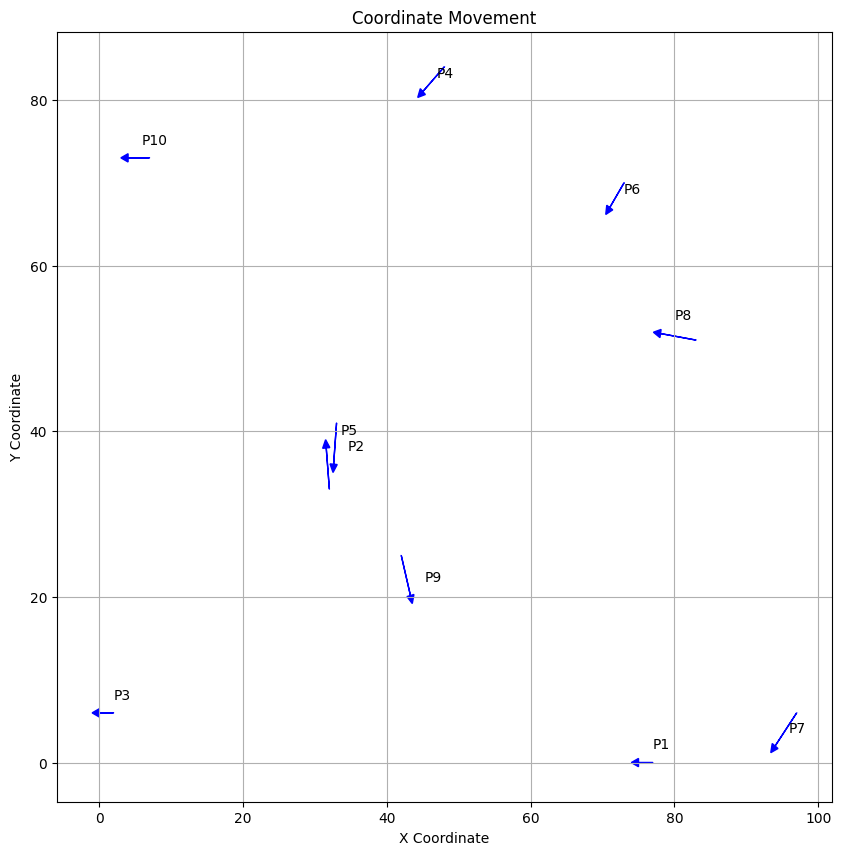

In [131]:
print("moved", environment.coordinates_histories[1])
print("gene: ", environment.agents[0].gene)
print("prompt_histories: ", environment.agents[0].prompt_histories)
print("talk_histories: ", environment.agents[0].talk_histories)
display_agent_move(environment.coordinates_histories[0], environment.coordinates_histories[1])


### Round 2

mutation: 明日香: 結婚 -> 絵空事


mutation: 強い 本能: 絵空事 -> 結婚
mutation: 温もり: 温もり -> 意匠性


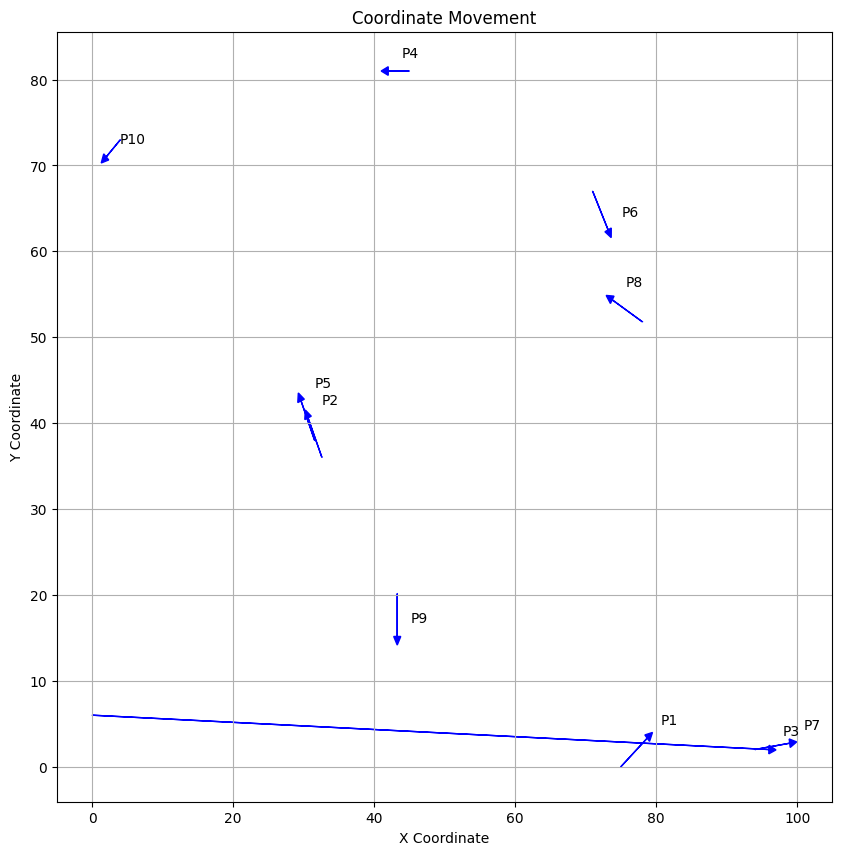

In [132]:
environment.run()
display_agent_move(environment.coordinates_histories[1], environment.coordinates_histories[2])

### Round 3

mutation: 強い 本能: 絵空事 -> 結婚
mutation: 公立 小中学校: 過疎 -> 華やかさ


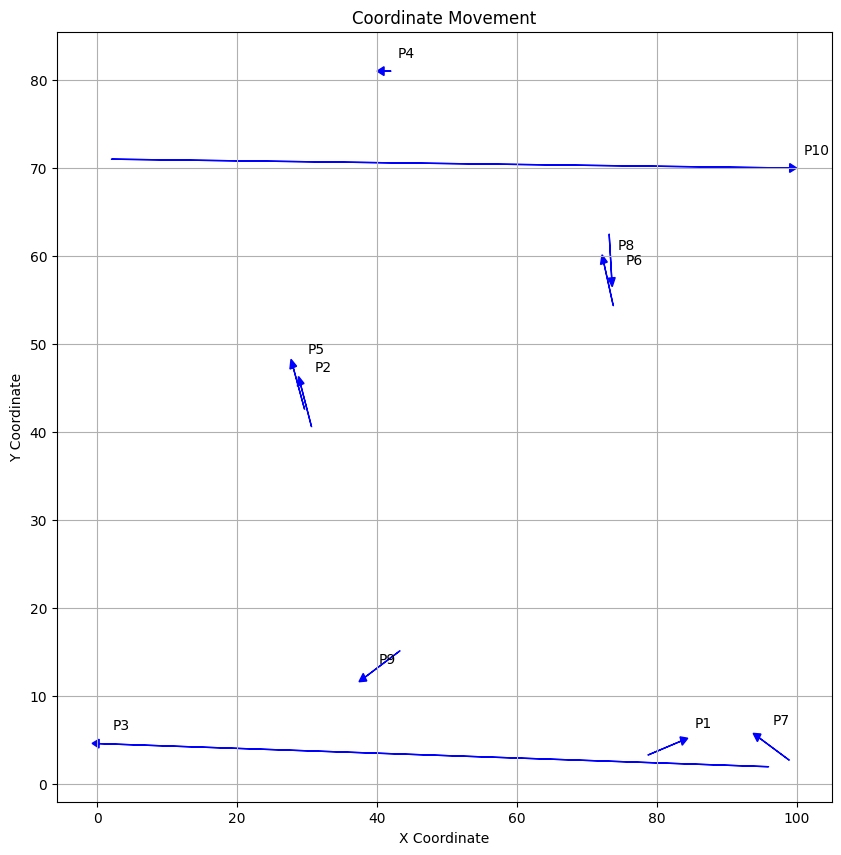

In [133]:
environment.run()
display_agent_move(environment.coordinates_histories[2], environment.coordinates_histories[3])

### Round 4

mutation: 明日香: 結婚 -> 絵空事


mutation: 温もり: 温もり -> 意匠性
mutation: 公立 小中学校: 過疎 -> 華やかさ


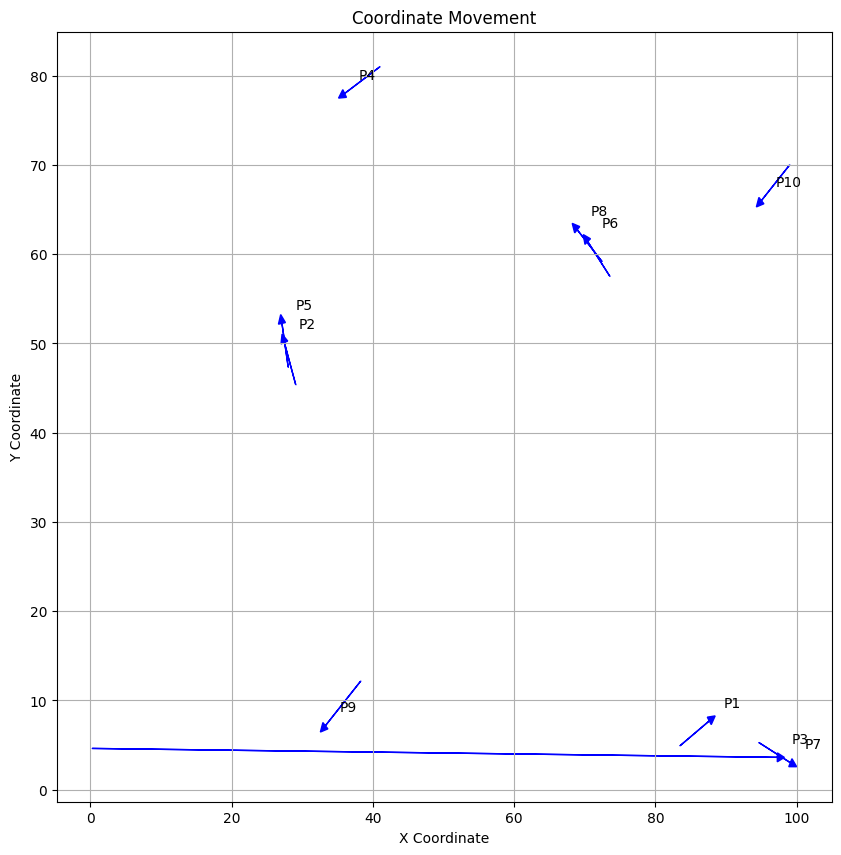

In [134]:
environment.run()
display_agent_move(environment.coordinates_histories[3], environment.coordinates_histories[4])

In [136]:
print(environment.agents[1].gene)
print(environment.agents[4].gene)

絵空事
結婚
